# Matching UAV and Satellite Images

- city = 'atlanta'
- number of uav imgs = 2078
- number of sat imgs = 2078


In [1]:
from torch import cuda

# train on GPU?
train_on_gpu = cuda.is_available()
print(f"Train on GPU: {train_on_gpu}")

# Number of GPUs
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f"{gpu_count} GPUs detected")
    
# change according to for hardware
batch_size = 128

Train on GPU: True
1 GPUs detected


## Image Pairs for Dataset

In [2]:
# Image directories
import os

data_dir = "train/"
city = 'atlanta'

uav_img_dir = data_dir + city + "/" + city + "_uav/uav/"
sat_img_dir = data_dir + city + "/" + city + "_sat/sat300/"

n_uav = len(os.listdir(uav_img_dir))
n_sat = len(os.listdir(sat_img_dir))
print(f"#Sat Images in {city} = {n_sat}")
print(f"#UAV Images in {city} = {n_uav}")

#Sat Images in atlanta = 2078
#UAV Images in atlanta = 2078


In [3]:
# load the match array
# A symmetric matrix, representing which uav image
# matches with which satellite image
import numpy as np
import h5py

filename = "data_labels.h5"
with h5py.File(filename, 'r') as f:
    print (list(f.keys()))
#     all_sat_LLAHTR = np.asarray(list(f['all_sat_LLAHTR']))
#     all_uav_LLAHTR = np.asarray(list(f['all_uav_LLAHTR']))
#     all_uav_xyzHTR = np.asarray(list(f['all_uav_xyzHTR']))
#     sat_img_path = list(f['sat300_image_paths'])
#     uav_img_path = list(f['uav_image_paths'])
    match_array = np.asarray(list(f['match_array_40']))
print(match_array)
print(match_array.shape)

['all_sat_LLAHTR', 'all_uav_LLAHTR', 'all_uav_xyzHTR', 'match_array_40', 'sat300_image_paths', 'uav_image_paths']
[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]
(30512, 30512)


In [4]:
# only for this city
match_array = match_array[0:2078,0:2078]
print(match_array.shape)

matching_pairs = np.transpose(np.nonzero(match_array))
print(matching_pairs)

(2078, 2078)
[[   0    0]
 [   0   10]
 [   0   15]
 ...
 [2075 2075]
 [2076 2076]
 [2077 2077]]


In [5]:
print(len(matching_pairs))

3896


In [6]:
# Generate same number of non-matching pairs
non_match_pairs = []
for i in range(len(match_array)):
    match_idx = np.nonzero(match_array[i,:])
    match_idx = np.asarray(match_idx)
    for j in range(match_idx.size):
        rand_idx = np.random.randint(len(match_array))
        while(rand_idx in match_idx):
            rand_idx = np.random.randint(len(match_array))
        non_match_pairs.append(np.array([i, rand_idx]))
non_match_pairs = np.asarray(non_match_pairs)
print(non_match_pairs)

[[   0  949]
 [   0 1731]
 [   0  835]
 ...
 [2075 1180]
 [2076 1431]
 [2077 2070]]


In [7]:
print(len(non_match_pairs))

3896


In [8]:
# We choose 780 pairs for validation set
choose_idx_match = []
choose_idx_nonmt = []
n_validby2 = 390
# 390 random indices from 0 to 3895
while(len(choose_idx_match) < n_validby2):
    to_append = np.random.randint(len(matching_pairs))
    if to_append not in choose_idx_match:
        choose_idx_match.append(to_append)

# 390 random indices from 0 to 3895        
while(len(choose_idx_nonmt) < n_validby2):
    to_append = np.random.randint(len(non_match_pairs))
    if to_append not in choose_idx_nonmt:
        choose_idx_nonmt.append(to_append)
        
print(len(choose_idx_match), len(choose_idx_nonmt))


390 390


In [9]:
valid_pairs = np.concatenate((matching_pairs[choose_idx_match], non_match_pairs[choose_idx_nonmt]), axis = 0)
print('valid_pairs',valid_pairs)
print('valid_pairs.shape',valid_pairs.shape)
valid_labels = np.concatenate((np.ones(n_validby2),np.zeros(n_validby2)))
print('len(valid_labels)', len(valid_labels))

valid_pairs [[ 187  191]
 [1460 1473]
 [1994 1994]
 ...
 [ 975 1042]
 [1079  527]
 [   5  464]]
valid_pairs.shape (780, 2)
len(valid_labels) 780


In [10]:
# Keep rest of the image pairs in training set
mask_match = np.ones(len(matching_pairs), dtype = bool)
mask_match[choose_idx_match] = False
mask_nonmt = np.ones(len(non_match_pairs), dtype = bool)
mask_nonmt[choose_idx_nonmt] = False
# print(len(non_match_pairs))
train_match_pairs = matching_pairs[mask_match]
train_nonmt_pairs = non_match_pairs[mask_nonmt]
# print('matching pairs for training \n', train_match_pairs.shape, train_match_pairs)
# print('non-matching pairs for training \n', train_nonmt_pairs.shape, train_nonmt_pairs)
train_pairs = np.concatenate((train_match_pairs, train_nonmt_pairs), axis = 0)
print(len(train_pairs), train_pairs)
n_trainby2 = len(matching_pairs) - n_validby2
train_labels = np.concatenate((np.ones(n_trainby2), np.zeros(n_trainby2)))
print(len(train_labels), train_labels)


7012 [[   0    0]
 [   0   10]
 [   0   15]
 ...
 [2075 1180]
 [2076 1431]
 [2077 2070]]
7012 [1. 1. 1. ... 0. 0. 0.]


In [11]:
# save valid and train pairs
import pickle
tp_file = 'results/siamese0/train_pair'
vp_file = 'results/siamese0/valid_pair'
with open(tp_file, 'wb') as f:
    pickle.dump(train_pairs, f)
with open(vp_file, 'wb') as f:
    pickle.dump(valid_pairs, f)

In [12]:
# write code to load the valid and train pairs

# no need to write code for train and valid labels

## Make dataset class and dataloader

In [13]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import io, transform 
# skimage transform is required for custom Rescale function

class GeoDataset(Dataset):
    '''
    dataset for uav and satellite images
    '''
    def __init__(self, uav_dir, sat_dir, img_pair_idx, labels, transform):
        # TODO: This needs to be changed when using the entire dataset, or multiple cities 
        self.uav_dir = uav_dir
        self.sat_dir = sat_dir
        self.img_pair_idx = img_pair_idx
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return self.labels.size
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        uav_img_name = os.path.join(self.uav_dir, "uav" + str(self.img_pair_idx[idx][0]) + ".png")
        sat_img_name = os.path.join(self.sat_dir, "sat" + str(self.img_pair_idx[idx][1]) + ".png")
        uav_img = io.imread(uav_img_name)
        sat_img = io.imread(sat_img_name)
        label = self.labels[idx]

        sample = {'uav_image': uav_img, 'satellite_image': sat_img, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [14]:
# redefine Rescale and ToTensor in order to work on pair of images
# regular functions in torchvision.transforms will not work

class Rescale(object):
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        uav_img, sat_img = sample['uav_image'], sample['satellite_image']
        label = sample['label']
        h, w = uav_img.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
#         print(new_h, new_w)
        uav_image = transform.resize(uav_img, (new_h, new_w))
#         using shortcut because we know both sizes are the same
        sat_image = transform.resize(sat_img, (new_h, new_w))

        return {'uav_image': uav_image, 'satellite_image': sat_image, 'label': label}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        uav_img, sat_img, label = sample['uav_image'], sample['satellite_image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        uav_img = uav_img.transpose((2, 0, 1)) # note that range is 0-255 not 0-1
        sat_img = sat_img.transpose((2, 0, 1))
        return {'uav_image': torch.from_numpy(uav_img),
                'satellite_image': torch.from_numpy(sat_img),
                'label': torch.from_numpy(np.asarray(label))}


In [15]:
# TODO: change the arguments when using the entire dataset, or different cities
train_dataset = GeoDataset(uav_img_dir, sat_img_dir, train_pairs, train_labels, 
                         transform = transforms.Compose([Rescale(256),
                                                        ToTensor()
                                                        ]))
valid_dataset = GeoDataset(uav_img_dir, sat_img_dir, train_pairs, train_labels, 
                         transform = transforms.Compose([Rescale(256),
                                                        ToTensor()
                                                        ]))

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure()

for i in range(4):#(len(mini_dataset)):
    sample = train_dataset[i]
    print(sample['label'])
    ax = plt.subplot(2, 4, 2*i + 1)
    # plt.tight_layout()
    ax.set_title('UAV #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['uav_image'].numpy().transpose((1, 2, 0)))
    ax = plt.subplot(2, 4, 2*i + 2)
    # plt.tight_layout()
    ax.set_title('SAT #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['satellite_image'].numpy().transpose((1, 2, 0)))
plt.plot()
plt.show()

tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor(1., dtype=torch.float64)


<Figure size 640x480 with 8 Axes>

In [17]:
# dataloaders: for training batch by batch as allowed by hardware
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    'valid': DataLoader(valid_dataset, batch_size=batch_size, shuffle=False),
}


In [18]:
len(dataloaders['train'].dataset)  # this is the number of examples in the entire dataset

7012

In [19]:
len(dataloaders['train']) # this depends on the batch size

55

## Network Architecture

Use 2 AlexNets, pretrained on ImageNet data, remove the last classifier layer from both.
Take the euclidean distance from both the networks as the output.

In [20]:
import torch.nn as nn
import torchvision.models as models
alex_GE = models.alexnet(pretrained = True)
alex_GM = models.alexnet(pretrained = True)

alex_GE.classifier = nn.Sequential(*[alex_GE.classifier[i] for i in range(5)])
alex_GM.classifier = nn.Sequential(*[alex_GM.classifier[i] for i in range(5)])

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.GE = alex_GE
        self.GM = alex_GM
    def forward(self, input1, input2):
        output1 = self.GE(input1)
        output2 = self.GM(input2)
        output = torch.norm(output1 - output2, p=2, dim=1)
        return output

model = SiameseNetwork()
if train_on_gpu:
    model = model.to('cuda')

## Loss Function
Contrastive loss function with a margin of 100

In [21]:
from torch import optim
# optimizer = optim.SGD(model.parameters(), lr=1e-05, weight_decay=5e-05, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.0005)
model.optimizer = optimizer

def loss_contrastive(euclidean_distance, label_batch):
    margin = 100
    loss = torch.mean( (label_batch) * torch.pow(euclidean_distance, 2) +
                    (1-label_batch) * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    return loss

## TRAIN

In [22]:
# training
from timeit import default_timer as timer
history = []
n_epochs = 150
model.epochs = 0
print_every = 22 # 110 batches will go in, print 5 times (in 1 epoch)
time0 = timer()

for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # set to train mode
    model.train()
    start = timer()
    
    for ii, sample in enumerate(dataloaders['train']):
#         TODO: CORRECT THE NON GPU PART
        if train_on_gpu:
            uav_img = sample['uav_image'].cuda()
            sat_img = sample['satellite_image'].cuda()
            label = sample['label'].cuda()
        uav_img = uav_img.float()
        sat_img = sat_img.float()
        label = label.float()
        # Clear gradients
        optimizer.zero_grad()
        # Predicted outputs are log probabilities
        output = model(uav_img, sat_img)
        
        # Loss and backpropagation of gradients
        loss = loss_contrastive(output, label)
        loss.backward()
        # Update the parameters
        optimizer.step()
#         print('loss.item()',loss.item()) #average loss for the batch_size
        # Track train loss by multiplying average loss by number of examples in batch
        train_loss += loss.item() * uav_img.size(0) # total loss in 1 epoch = sum of losses in all batch
        
        if (ii % print_every) == 0 :
#             print(uav_img.size(0)) this is basically the batch size
            print(f'phase=train, Epoch: {epoch}')
            print('% complete',round((100 * (ii + 1) / len(dataloaders['train'])),2)) 
            print('time: ',round(timer() - start,2))
        
    model.epochs += 1
    
    # Don't need to keep track of gradients
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        print('valid_loop', epoch)
        # Validation loop
        for ii, sample in enumerate(dataloaders['valid']):
            
            if train_on_gpu:
                uav_img = sample['uav_image'].cuda()
                sat_img = sample['satellite_image'].cuda()
                label = sample['label'].cuda()
            uav_img = uav_img.float()
            sat_img = sat_img.float()
            label = label.float()
            output = model(uav_img, sat_img)
            # Loss and backpropagation of gradients
            loss = loss_contrastive(output, label)
            valid_loss += loss.item() * uav_img.size(0)
            
    # Calculate average losses
    train_loss = train_loss / len(dataloaders['train'].dataset) #total loss / number of img pairs in the dataset
    valid_loss = valid_loss / len(dataloaders['valid'].dataset)
                
    history.append([train_loss, valid_loss])
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.4f}')
    print(f'Epoch: {epoch} \tValidation Loss: {valid_loss:.4f}')
    print('Average time per epoch in seconds = ', round((timer() - time0)/(epoch+1), 2))
print('Total time for training in min = ', round((timer() - time0)/60,2))        

phase=train, Epoch: 0
% complete 1.82
time:  13.72
phase=train, Epoch: 0
% complete 41.82
time:  254.41
phase=train, Epoch: 0
% complete 81.82
time:  494.78
valid_loop 0
Epoch: 0 	Training Loss: 5864.4720
Epoch: 0 	Validation Loss: 2554.0345
Average time per epoch in seconds =  1068.24
phase=train, Epoch: 1
% complete 1.82
time:  10.82
phase=train, Epoch: 1
% complete 41.82
time:  248.96
phase=train, Epoch: 1
% complete 81.82
time:  487.13
valid_loop 1
Epoch: 1 	Training Loss: 2563.0820
Epoch: 1 	Validation Loss: 2588.4724
Average time per epoch in seconds =  1064.48
phase=train, Epoch: 2
% complete 1.82
time:  10.82
phase=train, Epoch: 2
% complete 41.82
time:  249.18
phase=train, Epoch: 2
% complete 81.82
time:  487.47
valid_loop 2
Epoch: 2 	Training Loss: 2574.6472
Epoch: 2 	Validation Loss: 2491.9399
Average time per epoch in seconds =  1063.06
phase=train, Epoch: 3
% complete 1.82
time:  10.86
phase=train, Epoch: 3
% complete 41.82
time:  249.07
phase=train, Epoch: 3
% complete 81

phase=train, Epoch: 28
% complete 81.82
time:  492.11
valid_loop 28
Epoch: 28 	Training Loss: 1052.2507
Epoch: 28 	Validation Loss: 814.7923
Average time per epoch in seconds =  1064.86
phase=train, Epoch: 29
% complete 1.82
time:  10.85
phase=train, Epoch: 29
% complete 41.82
time:  249.62
phase=train, Epoch: 29
% complete 81.82
time:  488.42
valid_loop 29
Epoch: 29 	Training Loss: 1073.0915
Epoch: 29 	Validation Loss: 830.9181
Average time per epoch in seconds =  1064.8
phase=train, Epoch: 30
% complete 1.82
time:  10.93
phase=train, Epoch: 30
% complete 41.82
time:  251.26
phase=train, Epoch: 30
% complete 81.82
time:  493.19
valid_loop 30
Epoch: 30 	Training Loss: 1094.7027
Epoch: 30 	Validation Loss: 801.9762
Average time per epoch in seconds =  1065.18
phase=train, Epoch: 31
% complete 1.82
time:  11.03
phase=train, Epoch: 31
% complete 41.82
time:  251.24
phase=train, Epoch: 31
% complete 81.82
time:  493.65
valid_loop 31
Epoch: 31 	Training Loss: 1052.9864
Epoch: 31 	Validation

valid_loop 56
Epoch: 56 	Training Loss: 611.4226
Epoch: 56 	Validation Loss: 346.4925
Average time per epoch in seconds =  1068.4
phase=train, Epoch: 57
% complete 1.82
time:  10.84
phase=train, Epoch: 57
% complete 41.82
time:  250.5
phase=train, Epoch: 57
% complete 81.82
time:  489.7
valid_loop 57
Epoch: 57 	Training Loss: 590.7284
Epoch: 57 	Validation Loss: 340.9157
Average time per epoch in seconds =  1068.34
phase=train, Epoch: 58
% complete 1.82
time:  10.91
phase=train, Epoch: 58
% complete 41.82
time:  250.51
phase=train, Epoch: 58
% complete 81.82
time:  489.4
valid_loop 58
Epoch: 58 	Training Loss: 570.8478
Epoch: 58 	Validation Loss: 424.6640
Average time per epoch in seconds =  1068.37
phase=train, Epoch: 59
% complete 1.82
time:  10.87
phase=train, Epoch: 59
% complete 41.82
time:  250.58
phase=train, Epoch: 59
% complete 81.82
time:  489.8
valid_loop 59
Epoch: 59 	Training Loss: 586.4990
Epoch: 59 	Validation Loss: 332.8245
Average time per epoch in seconds =  1068.31
p

KeyboardInterrupt: 

### Train and Validation Loss

In [23]:
training_minutes = round((timer() - time0)/60, 2)

In [24]:
print(training_minutes)

1291.41


In [25]:
history

[[5864.471988310218, 2554.034488031678],
 [2563.082045177018, 2588.4724202566804],
 [2574.647179054656, 2491.939918983751],
 [2457.454252809915, 2369.5261637137673],
 [2098.326333149868, 1838.993335225551],
 [2055.211694642332, 1767.2510250285225],
 [1885.546678907587, 1699.0764378810431],
 [1892.882602341299, 1920.383260392898],
 [1820.1024138586085, 1556.0136310688374],
 [1887.003687038737, 1844.7379497869724],
 [1762.4563780728572, 1569.0519195051786],
 [1668.9610601273932, 1573.1278782968036],
 [1696.4983883654807, 1620.5760477852698],
 [1651.3524339831495, 1515.04477863562],
 [1618.2456292839506, 1430.3955383126693],
 [1690.9175774704302, 1440.4695447452805],
 [1474.6355804251864, 1307.1499765747558],
 [1474.4325332772166, 1448.7968628834944],
 [1411.512828733332, 1171.5712227002593],
 [1379.352112826115, 1114.1355836284004],
 [1434.3082393770278, 1359.051456222926],
 [1391.2769561610899, 1105.464177829636],
 [1379.4517809034958, 1066.1014077011953],
 [1325.0322461995954, 990.7200

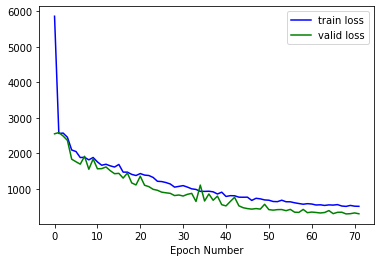

In [26]:
train_history = []
valid_history = []
for ii, i in enumerate(history):
#     if ii<=1:
#         continue
    train_history.append(i[0])
    valid_history.append(i[1])
plt.plot(range(len(train_history)), train_history, 'b-', label='train loss')
plt.plot(range(len(valid_history)), valid_history, 'g-', label='valid loss')
plt.legend(loc='best')
plt.xlabel('Epoch Number')
plt.show()

## Save Model

In [27]:
# model saving stuff here
def save_checkpoint(model, path):
    checkpoint = {'epochs': model.epochs}
    checkpoint['state_dict'] = model.state_dict()
    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()
    # train loss
    checkpoint['train_loss'] = train_history
    checkpoint['valid_loss'] = valid_history
    checkpoint['training_minutes'] = training_minutes
    torch.save(checkpoint, path)

In [28]:
checkpoint_path = "results/siamese0/atlanta_sia_alex.pth"
save_checkpoint(model, checkpoint_path)

## Load Model

In [ ]:
# Load the saved model
import torch

def load_checkpoint(path):
    model = SiameseNetwork()
    if train_on_gpu:
        model = model.to('cuda')
    
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    if train_on_gpu:
        model = model.to('cuda')
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [ ]:
# go and run everything except the training and saving cell
PATH = "results/siamese0/atlanta_sia_alex.pth"
model, optimizer = load_checkpoint(PATH)

## Performance Check
Draw distance histograms

In [30]:
# make histograms for matching and non-matching pairs
train_match_hist = []
train_nonma_hist = []
with torch.no_grad():
    model.eval()
    for ii, sample in enumerate(dataloaders['train']):
        if train_on_gpu:
            uav_img = sample['uav_image'].cuda()
            sat_img = sample['satellite_image'].cuda()
            label = sample['label'].cuda()
        uav_img = uav_img.float()
        sat_img = sat_img.float()
        label = label.float()
        output = model(uav_img, sat_img)
        out = output.cpu().detach().numpy()

        for i in range(len(output)):
            if (label[i]):
                train_match_hist.append(out[i])
            else:
                train_nonma_hist.append(out[i])
            
print(len(train_match_hist))
print(len(train_nonma_hist))

3506
3506


(array([  1.,  90., 121., 114., 112.,  96., 104., 108., 118., 110., 120.,
        103.,  88.,  95.,  96., 119., 102.,  76., 111.,  89.,  81.,  93.,
         85.,  89.,  82.,  55.,  66.,  59.,  64.,  47.,  63.,  56.,  56.,
         50.,  35.,  42.,  35.,  39.,  41.,  38.,  35.,  28.,  32.,  19.,
         33.,  26.,  29.,  18.,  12.,  11.,  14.,  12.,  11.,   8.,   8.,
          6.,   4.,   8.,   6.,   6.,   3.,   4.,   8.,   0.,   4.,   0.,
          2.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55

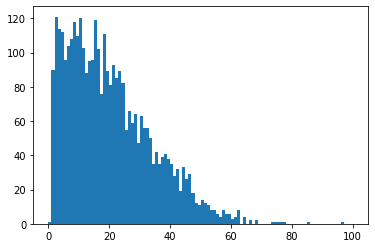

In [34]:
# train_match_plotter = []
# for i in train_match_hist:
#     train_match_plotter.append(i)
plt.hist(train_match_hist, range(int(max(train_match_hist))+1))

(array([ 0.,  0.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  1.,  0.,  3.,  0.,  2.,  0.,  0.,  4.,  3.,  3.,
         5.,  2.,  7.,  7.,  4.,  5.,  3.,  2.,  1.,  3.,  7.,  4.,  8.,
         6.,  4.,  6.,  9.,  6.,  8., 10., 11., 11., 19.,  7., 12., 21.,
        14., 19., 12., 15., 23.,  7., 12., 14., 19., 13., 19., 16., 13.,
        19., 23., 16., 21., 22., 27., 18., 22., 24., 22., 33., 26., 20.,
        30., 22., 24., 25., 25., 25., 30., 24., 32., 27., 34., 31., 23.,
        20., 27., 31., 30., 33., 28., 29., 26., 24., 15., 27., 28., 23.,
        27., 26., 21., 27., 27., 32., 21., 25., 26., 27., 18., 18., 10.,
        26., 24., 21., 21., 16., 22., 20., 22., 21., 34., 21., 15., 16.,
        20., 17., 17., 20., 22., 20., 14., 13., 15., 20., 14., 11., 16.,
        11., 21., 14., 18., 16., 12., 12., 12., 12., 11., 14., 11., 13.,
        17., 18., 10., 18., 10.,  8., 11.,  9., 16.,  7.,  7., 13.,  8.,
         7.,  8., 14., 14., 12.,  5., 14.,  9., 12.

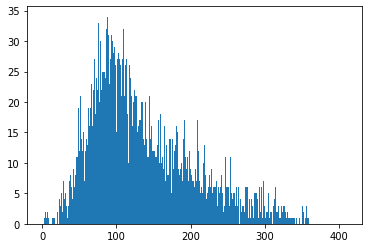

In [35]:
# train_nonma_plotter = []
# for i in train_nonma_hist:
#     train_nonma_plotter.append(i.cpu().detach().numpy())
plt.hist(train_nonma_hist, range(int(max(train_nonma_hist))+1))

In [36]:
# make histograms for matching and non-matching pairs
valid_match_hist = []
valid_nonma_hist = []

with torch.no_grad():
    for ii, sample in enumerate(dataloaders['valid']):
        if train_on_gpu:
            uav_img = sample['uav_image'].cuda()
            sat_img = sample['satellite_image'].cuda()
            label = sample['label'].cuda()
        uav_img = uav_img.float()
        sat_img = sat_img.float()
        label = label.float()
        model.eval()
        output = model(uav_img, sat_img)
        out = output.cpu().detach().numpy()
        # out = out.detach().numpy()
        for i in range(len(output)):
            if (label[i]):
                valid_match_hist.append(out[i])
            else:
                valid_nonma_hist.append(out[i])
            
print(len(valid_match_hist))
print(len(valid_nonma_hist))

3506
3506


(array([  1.,  90., 121., 114., 112.,  96., 104., 108., 118., 110., 120.,
        103.,  88.,  95.,  96., 119., 102.,  76., 111.,  89.,  81.,  93.,
         85.,  89.,  82.,  55.,  66.,  59.,  64.,  47.,  63.,  56.,  56.,
         50.,  35.,  42.,  35.,  39.,  41.,  38.,  35.,  28.,  32.,  19.,
         33.,  26.,  29.,  18.,  12.,  11.,  14.,  12.,  11.,   8.,   8.,
          6.,   4.,   8.,   6.,   6.,   3.,   4.,   8.,   0.,   4.,   0.,
          2.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55

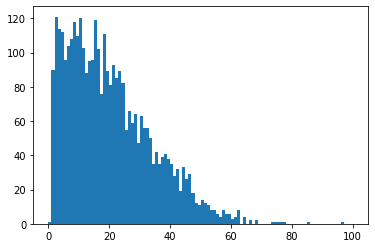

In [38]:
# valid_match_plotter = []
# for i in match_hist:
#     valid_match_plotter.append(i.cpu().detach().numpy())
plt.hist(valid_match_hist, range(int(max(valid_match_hist))+1))

(array([ 0.,  0.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  1.,  0.,  3.,  0.,  2.,  0.,  0.,  4.,  3.,  3.,
         5.,  2.,  7.,  7.,  4.,  5.,  3.,  2.,  1.,  3.,  7.,  4.,  8.,
         6.,  4.,  6.,  9.,  6.,  8., 10., 11., 11., 19.,  7., 12., 21.,
        14., 19., 12., 15., 23.,  7., 12., 14., 19., 13., 19., 16., 13.,
        19., 23., 16., 21., 22., 27., 18., 22., 24., 22., 33., 26., 20.,
        30., 22., 24., 25., 25., 25., 30., 24., 32., 27., 34., 31., 23.,
        20., 27., 31., 30., 33., 28., 29., 26., 24., 15., 27., 28., 23.,
        27., 26., 21., 27., 27., 32., 21., 25., 26., 27., 18., 18., 10.,
        26., 24., 21., 21., 16., 22., 20., 22., 21., 34., 21., 15., 16.,
        20., 17., 17., 20., 22., 20., 14., 13., 15., 20., 14., 11., 16.,
        11., 21., 14., 18., 16., 12., 12., 12., 12., 11., 14., 11., 13.,
        17., 18., 10., 18., 10.,  8., 11.,  9., 16.,  7.,  7., 13.,  8.,
         7.,  8., 14., 14., 12.,  5., 14.,  9., 12.

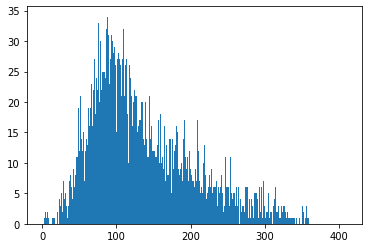

In [39]:
# valid_nonma_plotter = []
# for i in valid_nonma_hist:
#     valid_nonma_plotter.append(i.cpu().detach().numpy())
plt.hist(valid_nonma_hist, range(int(max(valid_nonma_hist))+1))

## Make Inference

In [40]:
def make_prediction(uav_img_path, sat_img_path, true_label, model):
    uav_img = io.imread(uav_img_path)
    sat_img = io.imread(sat_img_path)
    sample = {'uav_image': uav_img, 'satellite_image': sat_img, 'label':true_label}

    single_transform = transforms.Compose([Rescale(256),ToTensor()])
    sample = single_transform(sample)

    uav_img = (sample['uav_image']).float()
    sat_img = (sample['satellite_image']).float()
    if train_on_gpu:
        uav_img = uav_img.view(1, 3, 256, 256).cuda()
        sat_img = sat_img.view(1, 3, 256, 256).cuda()
        # Set to evaluation
#     TODO: if train_on_gpu is False
    with torch.no_grad():
        model.eval()
        out = model(uav_img, sat_img)
        print('Actual value ', true_label)
        print('Distance is ', out)

In [42]:
# choose in range 0 to 148
test_uav_no = 185
test_sat_no = 186
test_uav = uav_img_dir + 'uav' + str(test_uav_no) + '.png'
test_sat = sat_img_dir + 'sat' + str(test_sat_no) + '.png'
true_label = match_array[test_uav_no, test_sat_no]
make_prediction(test_uav, test_sat, true_label, model)

Actual value  False
Distance is  tensor([111.1536], device='cuda:0')
